In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
import networkx as nx
from IPython.display import clear_output

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
colors = plt.cm.magma(np.linspace(.3,1,8))

In [ ]:
def get_coloring(S):
    """
    Compute a greedy graph coloring for the column conflict graph of sparsity pattern S.
    
    The coloring allows efficient batching of matrix-vector products: columns with the 
    same color have disjoint support and can be queried simultaneously.
    
    Parameters
    ----------
    S : ndarray of shape (n, d)
        Binary sparsity pattern matrix where S[i,j] = 1 indicates that entry (i,j) is nonzero
    
    Returns
    -------
    colors : ndarray of shape (d,)
        Color assignment for each column, where colors[j] is an integer in [0, k-1] for k total colors
    
    Algorithm
    ---------
    1. Construct conflict graph G where:
       - Nodes represent columns of S
       - Edges (i,j) exist if columns i and j have overlapping support: (S^T @ S)[i,j] > 0
    2. Apply NetworkX greedy coloring algorithm to find coloring
    
    Notes
    -----
    - The chromatic number k (number of colors) is at most s (row sparsity) but can be much smaller
    - Greedy coloring is not optimal but provides good approximation in practice
    - Columns with same color can be safely queried together as they don't interfere
    """
    
    n, d = S.shape
    
    # Construct column conflict graph: G[i,j] = (S^T @ S)[i,j]
    # Two columns conflict if their supports overlap
    G = nx.from_numpy_array(S.T @ S)
    
    # Apply greedy graph coloring
    nx_color = nx.greedy_color(G)
    
    # Convert dictionary to array
    colors = np.array([nx_color[i] for i in range(d)])

    return colors

In [ ]:
def coloring_recovery(A, S, coloring, m):
    """
    Sparse recovery algorithm exploiting graph coloring to reduce matvec complexity.
    
    This algorithm uses the graph coloring of the sparsity pattern to batch queries
    efficiently. Instead of solving least squares for each row (cost O(ms²n)), we 
    use color classes to recover entries with cost O(md).
    
    Parameters
    ----------
    A : ndarray of shape (n, d)
        Matrix to approximate (not necessarily sparse)
    S : ndarray of shape (n, d)
        Binary sparsity pattern matrix
    coloring : ndarray of shape (d,)
        Column coloring where coloring[j] ∈ [0, k-1] for k colors
    m : int
        Number of matrix-vector products to use
    
    Returns
    -------
    A_ : ndarray of shape (n, d)
        Sparse approximation satisfying supp(A_) ⊆ supp(S)
    
    Algorithm
    ---------
    1. Construct mask matrix from coloring (mask[i,c] = 1 if column i has color c)
    2. Generate structured random test matrix:
       - G is tiled repetition of mask with random ±1 scaling
       - This ensures columns of same color are queried together
    3. Compute Z = A @ G (m matrix-vector products)
    4. For each color c:
       - Average Z[:,c::k] to reduce variance
       - Multiply by (S @ G[:,c::k]) and mask to recover entries with color c
    
    Complexity
    ----------
    Time: O(m·d + k·n·d) ≈ O(m·d) when m >> k
    Space: O(n·d + d·m)
    Error: ||S∘A - A_||_F = O(√(k/(m-k-1))) · ||S∘A||_F for m > k+1
    
    Notes
    -----
    - Requires k << s for advantage over sparse_recovery
    - Works best when coloring number k is small
    - More memory efficient than least squares approach
    """

    n, d = A.shape
    
    # Number of colors in the coloring
    c = max(coloring) + 1
    
    # Construct mask matrix: mask[i,j] = 1 if column i has color j
    mask = np.zeros((d, c))
    for i in range(c):
        mask[coloring == i, i] = 1
    
    # Generate structured random test matrix by tiling mask
    # Each repetition of mask gets random ±1 scaling
    G = np.tile(mask, int(np.ceil(m / c)))[:, :m] * np.random.choice([-1, 1], size=(d, m))
    
    # Compute matrix-vector products (m total)
    Z = A @ G
    
    # Initialize approximation
    A_ = np.zeros((n, d))
    
    # Recover entries for each color class
    for i in range(c):
        # For color i, average across all matvecs with that color (reduces variance)
        # S @ G[:,i::c] gives expected value, Z[:,i::c] gives observations
        # Product (S @ G[:,i::c]) * Z[:,i::c] gives unbiased estimate
        # Mask by S[:,coloring==i] to enforce sparsity
        A_[:, coloring == i] += S[:, coloring == i] * np.mean((S @ G[:, i::c]) * Z[:, i::c], axis=1)[:, None]
    
    return A_

In [ ]:
def sparse_recovery(A, S, m):
    """
    Sparse recovery algorithm using independent least squares for each row.
    
    This is the baseline algorithm from [ACHKMM24] that recovers each row of A
    independently by solving a least squares problem on the support defined by S.
    
    Parameters
    ----------
    A : ndarray of shape (n, d)
        Matrix to approximate (not necessarily sparse)
    S : ndarray of shape (n, d)
        Binary sparsity pattern matrix where S[i,j] = 1 indicates entry (i,j) should be recovered
    m : int
        Number of random matrix-vector products to use for recovery
    
    Returns
    -------
    A_ : ndarray of shape (n, d)
        Sparse approximation of A where supp(A_) ⊆ supp(S)
    
    Algorithm
    ---------
    For each row i ∈ [n]:
        1. Let s_i = {j : S[i,j] = 1} be the support of row i
        2. Generate random Gaussian test matrix G ∈ ℝ^(d×m)
        3. Compute Z[i] = A[i,:] @ G via matrix-vector products
        4. Solve least squares: A_[i, s_i] = argmin_x ||G[s_i,:]^T @ x - Z[i]||²
    
    Complexity
    ----------
    Time: O(n·m·s²) where s = max_i |s_i| is the maximum row sparsity
        - Each row requires solving s×s least squares problem
    Space: O(d·m) for test matrix G
    Error: ||S∘A - A_||_F = O(√(s/(m-s-1))) · ||S∘A||_F for m > s+1
    
    Notes
    -----
    - Requires m > s for least squares to be well-posed
    - Works well when s is small
    - Each row recovered independently (embarrassingly parallel)
    - Uses numpy.linalg.lstsq with rcond=None for numerical stability
    
    References
    ----------
    [ACHKMM24] Reference to be inserted
    """
    
    n, d = A.shape
    
    # Generate random Gaussian test matrix
    G = np.random.randn(d, m)
    
    # Compute all matrix-vector products: Z = A @ G
    Z = A @ G

    # Initialize sparse approximation
    A_ = np.zeros((n, d))

    # Recover each row independently via least squares
    for i in range(n):
        # Get support (nonzero indices) for row i
        si = np.where(S[i])[0]
        
        # Solve least squares problem: min ||G[si,:]^T @ x - Z[i]||²
        # This recovers A[i, si] from the measurements Z[i]
        A_[i, si] = np.linalg.lstsq(G[si].T, Z[i], rcond=None)[0]

    return A_

# Model Problem

In [27]:
n = 1000
B = np.diag(4*np.ones(n)) + np.diag(-np.ones(n-1),1) + np.diag(-np.ones(n-1),-1)
A = np.linalg.inv(B)
A /= np.linalg.norm(A)

bs = [0,1,2,3,4]
ms = np.geomspace(1,5e2+1,20,dtype=int)
n_trials = 100


In [8]:


err_all = {}
err_color_all = {}
err_opt_all = {}
for b in bs:

    err = np.full((len(ms),n_trials),np.nan)
    err_color = np.full((len(ms),n_trials),np.nan)

    s = 2*b+1
    S = np.eye(n,dtype=bool)
    for i in range(1,b+1):
        S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)

    coloring = np.arange(n)%s
    for i,m in enumerate(ms):
        print(f"{b},{m}")
        clear_output(wait=True)
        
        if m<s+2:
            continue
        for j in range(n_trials):
            A_ = sparse_recovery(A,S,m)
            err[i,j] = np.linalg.norm(A_ - A*S)

            A_ = coloring_recovery(A,S,coloring,m)
            err_color[i,j] = np.linalg.norm(A_ - A*S)

    err_all[b] = err
    err_color_all[b] = err_color
    err_opt_all[b] = np.linalg.norm(A-A*S)

4,501


In [28]:
# np.save('model.npy',[err_all,err_color_all,err_opt_all],allow_pickle=True)
[err_all,err_color_all,err_opt_all] = np.load('model.npy',allow_pickle=True)

/tmp/ipykernel_642078/404389838.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/404389838.py:17: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/404389838.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/404389838.py:26: RuntimeWarning: invalid value encountered in sqrt
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)


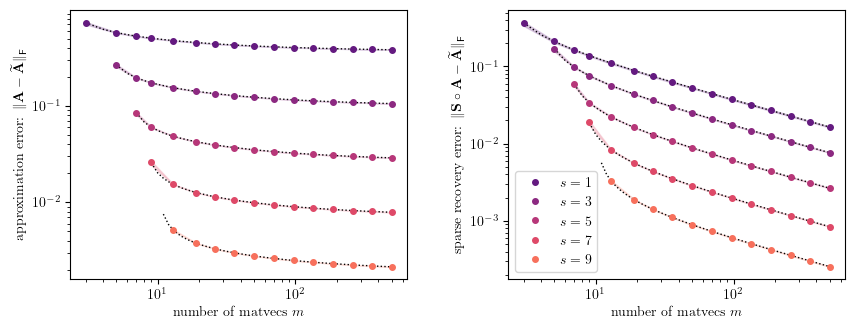

In [29]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = 2*b+1
    err = err_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')


    axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')


axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/inverse_decay.pdf')

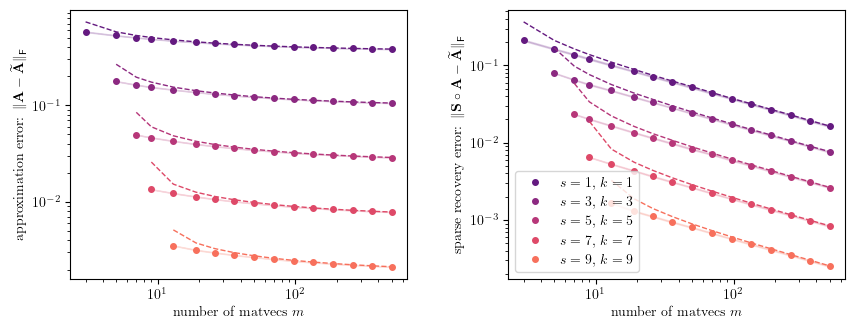

In [30]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = 2*b+1
    err = err_color_all[b]
    err_opt = err_opt_all[b]

    err_old = err_all[b]

    mean = np.mean(err**2,axis=1)**.5
    mean_old = np.mean(err_old**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    # axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
    axs[0].plot(ms,mean_old+err_opt,color=c,ls='--',lw=1)


    axs[0].plot(ms,err_opt+mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')


    # axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
    axs[1].plot(ms,mean_old,color=c,ls='--',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=4,color=c,ls='None',label=f'$s={s}$, $k={s}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')


axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/inverse_decay_color.pdf')

# Trefethen primes

In [12]:
n = 1000

b = 1

S = np.eye(n,dtype=bool)
for j in range(1,int(np.log2(n))):

    for i in range(2**j-b,2**j+b+1):
        S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)

s = np.max(np.sum(S,axis=0))

In [13]:
B = np.diag(list(sympy.primerange(2, sympy.prime(n) + 1)))
for j in range(1,int(np.log2(n))+1):
    i = 2**j
    B += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)


A = np.linalg.inv(B)

A /= np.linalg.norm(A)

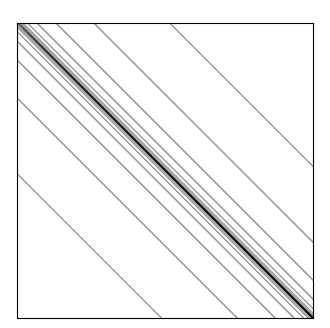

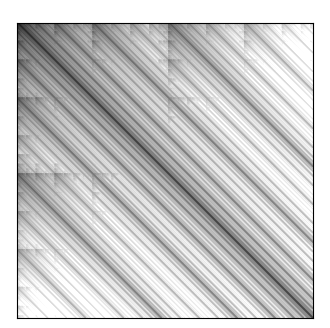

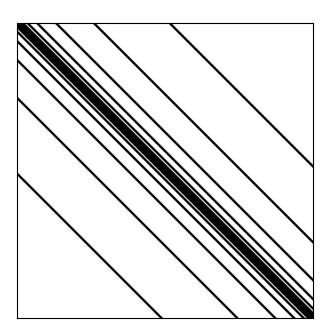

In [14]:
fig,axs = plt.subplots(2,1,figsize=(4,4),height_ratios=[1,36])
plt.subplots_adjust(hspace=.03)

axs[0].axis('off')

axs[1].imshow(np.abs(B),cmap='binary',norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e3))
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.savefig('imgs/tref_mat_orig.pdf')

b=5
S = np.zeros((n,n),dtype=bool)
for j in range(0,int(np.log2(n))+1):
    for i in range(max(0,2**j-b),min(2**j+b,n)+1):
        S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)


fig,axs = plt.subplots(2,1,figsize=(4,4),height_ratios=[1,36])
plt.subplots_adjust(hspace=.03)

axs[0].axis('off')

axs[1].imshow(np.abs(A),cmap='binary',norm=mpl.colors.LogNorm())
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.savefig('imgs/tref_mat.pdf')

fig,axs = plt.subplots(2,1,figsize=(4,4),height_ratios=[1,36])
plt.subplots_adjust(hspace=.03)

axs[0].axis('off')

axs[1].imshow(S,cmap='binary')
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.savefig('imgs/tref_sparsity.pdf')

In [15]:
bs = [0,1,2,5]
ms = np.geomspace(21,7e2+1,20,dtype=int)
n_trials = 100

In [16]:
s_all = {}
err_all = {}
err_color_all = {}
cond_all = {}
err_opt_all = {}
colorings = {}
for b in bs:

    err = np.full((len(ms),n_trials),np.nan)
    err_color = np.full((len(ms),n_trials),np.nan)
    cond = np.full((len(ms),n_trials),np.nan)

    S = np.zeros((n,n),dtype=bool)
    for j in range(0,int(np.log2(n))+1):
        for i in range(max(0,2**j-b),min(2**j+b,n)+1):
            S += np.diag(np.ones(n-i,dtype=bool),i) + np.diag(np.ones(n-i,dtype=bool),-i)

    coloring = get_coloring(S)
    colorings[b] = coloring

    s = np.max(np.sum(S,axis=0))
    s_all[b] = s
    
    for i,m in enumerate(ms):

        print(f"{b},{m}")
        clear_output(wait=True)

        if m<s+2: 
            continue
        for j in range(n_trials):
            A_ = sparse_recovery(A,S,m)
            err[i,j] = np.linalg.norm(A_ - A*S)

            A_ = coloring_recovery(A,S,coloring,m)
            err_color[i,j] = np.linalg.norm(A_ - A*S)


    err_all[b] = err
    err_color_all[b] = err_color
    err_opt_all[b] = np.linalg.norm(A-A*S)

5,701


In [17]:
np.save('trefethen_primes.npy',[err_all,err_color_all,err_opt_all,s_all,colorings],allow_pickle=True)
[err_all,err_color_all,err_opt_all,s_all,colorings] = np.load('trefethen_primes.npy',allow_pickle=True)

/tmp/ipykernel_642078/2180474405.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/2180474405.py:17: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/2180474405.py:26: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
/tmp/ipykernel_642078/2180474405.py:26: RuntimeWarning: invalid value encountered in sqrt
  axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)


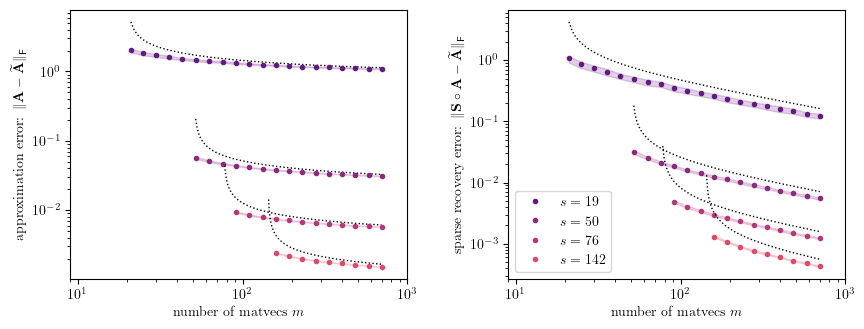

In [18]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = s_all[b]
    err = err_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim([9,1000])

    axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_xlim([9,1000])

axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/tref_inv.pdf')

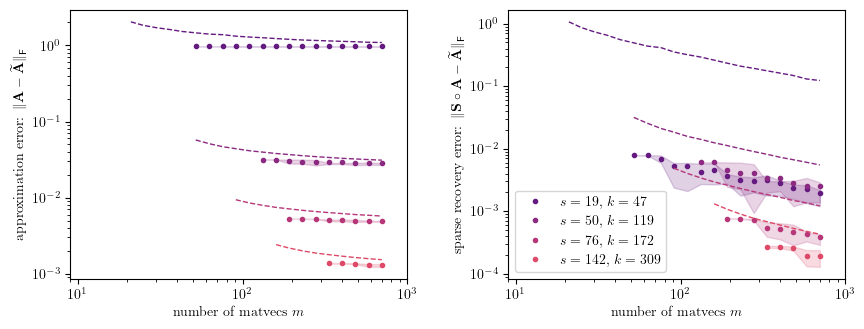

In [25]:
fig,axs = plt.subplots(1,2,figsize=(10,3.5))
plt.subplots_adjust(wspace=.3)

for i,b in enumerate(bs):
    c = colors[i]
    
    s = s_all[b]
    err = err_color_all[b]
    err_old = err_all[b]
    err_opt = err_opt_all[b]

    mean = np.mean(err**2,axis=1)**.5
    mean_old = np.mean(err_old**2,axis=1)**.5

    σ = 0.25
    minq = np.quantile(err,σ,axis=1)
    maxq = np.quantile(err,1-σ,axis=1)

    # axs[0].plot(np.arange(np.max(ms)),err_opt+np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
    axs[0].plot(ms,mean_old+err_opt,color=c,ls='--',lw=1)

    axs[0].plot(ms,err_opt+mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$')
    axs[0].fill_between(ms,err_opt+minq,err_opt+maxq,alpha=.2,color=c);

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim([9,1000])

    # axs[1].plot(np.arange(np.max(ms)),np.sqrt(s/(np.arange(np.max(ms))-s-1))*err_opt,color='k',ls=':',lw=1)
    axs[1].plot(ms,mean_old,color=c,ls='--',lw=1)

    axs[1].plot(ms,mean,marker='o',ms=3,color=c,ls='None',label=f'$s={s}$, $k={np.max(colorings[b])+1}$')
    axs[1].fill_between(ms,minq,maxq,alpha=.2,color=c);

    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_xlim([9,1000])

axs[0].set_ylabel('approximation error: $\|\mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')
axs[1].set_ylabel('sparse recovery error: $\|\mathbf{S}\circ \mathbf{A} - \widetilde{\mathbf{A}}\|_{\mathsf{F}}$')

axs[0].set_xlabel('number of matvecs $m$')
axs[1].set_xlabel('number of matvecs $m$')


plt.legend()

plt.savefig('imgs/tref_inv_color.pdf')